In [1]:
import jax
from IPython.display import Image as DisplayImage

from evojax import Trainer
from evojax.policy import MLPPolicy
from evojax.algo import PGPE
from evojax.task.flocking import FlockingTask
from evojax.util import create_logger

In [2]:
# Let's create a directory to save logs and models.
log_dir = './log'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('Welcome to the tutorial on Task creation!')

logger.info('Jax backend: {}'.format(jax.local_devices()))
!nvidia-smi --query-gpu=name --format=csv,noheader

EvoJAX: 2022-03-16 00:43:22,974 [INFO] Welcome to the tutorial on Task creation!
absl: 2022-03-16 00:43:22,980 [INFO] Starting the local TPU driver.
absl: 2022-03-16 00:43:22,981 [INFO] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
absl: 2022-03-16 00:43:23,917 [INFO] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
EvoJAX: 2022-03-16 00:43:23,918 [INFO] Jax backend: [GpuDevice(id=0, process_index=0)]


NVIDIA A100-SXM4-40GB


In [3]:
seed = 42
neighbor_num = 5

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150)
test_task = FlockingTask(150)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[60, 60],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

TypeError: __init__() takes from 1 to 2 positional arguments but 3 were given

reward=[-32.066147]


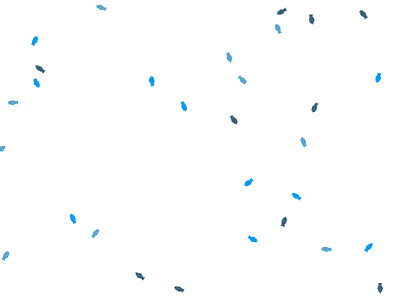

In [ ]:
# Let's visualize the learned policy.

def render(task, algo, policy):
    """Render the learned policy."""

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')